In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import sisl

In [2]:
syscoord = 'phenanthrene.xyz'

Not sure if we should use sisl. We could for instance read the xyz file excluding alreay the hydrogen atoms.

In [3]:
# Read geometry from 'xyz' file
geom = sisl.Geometry.read(syscoord)
print(geom)

Geometry{na: 24, no: 24,
 Atoms{species: 2,
  Atom{H, Z: 1, mass(au): 1.0079, maxR: -1.00000,
   Orbital{R: -1, q0: 0.0}
  }: 10,
  Atom{C, Z: 6, mass(au): 12.011, maxR: -1.00000,
   Orbital{R: -1, q0: 0.0}
  }: 14,
 },
 nsc: [1, 1, 1], maxR: -1
}


In [4]:
# remove hydrogen atoms
rmidx = np.where(geom.atoms.specie == 0)
system = sisl.Geometry(geom.remove(rmidx).xyz, sisl.Atom('C'))
print(system)

Geometry{na: 14, no: 14,
 Atoms{species: 1,
  Atom{C, Z: 6, mass(au): 12.011, maxR: -1.00000,
   Orbital{R: -1, q0: 0.0}
  }: 14,
 },
 nsc: [1, 1, 1], maxR: -1
}


In [5]:
# create a Hamiltonian object
Hsisl = sisl.Hamiltonian(system)
print(Hsisl)

Hamiltonian{non-zero: 0, orthogonal: True,
 Spin{unpolarized, kind=f},
 Geometry{na: 14, no: 14,
  Atoms{species: 1,
   Atom{C, Z: 6, mass(au): 12.011, maxR: -1.00000,
    Orbital{R: -1, q0: 0.0}
   }: 14,
  },
  nsc: [1, 1, 1], maxR: -1
 }
}


In [6]:
# build the first-neighbours Hamiltonian
for ia, io in Hsisl: # over all atoms and orbitals
    # list nearest neighbours
    idx = Hsisl.geom.close(ia, R = [0.1, 1.43])
    # on-site energy
    Hsisl[io, idx[0]] = 0
    # nearest-neighbour hopping
    Hsisl[io, idx[1]] = 1
    # put 1 in the diagonal when necessary
    Hsisl[io, io] = 3-len(idx[1])

In [7]:
# get an dense matrix of integers from sisl
H = Hsisl.Hk(format='dense').astype(int)
print(' ', end='')
for i in range(len(H)):
    print('%2d'%i, end='')
print('')
print(H)

  0 1 2 3 4 5 6 7 8 910111213
[[1 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 1 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 1 0 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 1]]


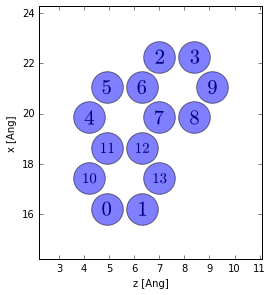

In [8]:
# visualize the structure (in the xz plane)
f, axs = plt.subplots(1, 1, figsize=(4, 10))
lb_x = system.xyz[:,0]
for j in range(len(H)):
    axs.scatter(system.xyz[j,2], lb_x[j], s=200, c='black',
                marker=r"$ {} $".format(str(j)), edgecolors='none')
    axs.scatter(system.xyz[j,2], system.xyz[j,0], s=1000, c='b', alpha=.5)
axs.set_xlim(min(system.xyz[:,2])-2., max(system.xyz[:,2])+2.);
axs.set_ylim(min(system.xyz[:,0])-2., max(system.xyz[:,0])+2.);
axs.set_xlabel('z [Ang]'); axs.set_ylabel('x [Ang]'); axs.set_aspect('equal');